In [1]:
#Benötigte Pakete
%matplotlib inline 
import numpy as np
import io
import csv
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy import odr
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from scipy.stats import chi2
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = 16, 9

In [2]:
def sig(val1,err1,val2,err2):
    sig = np.abs(val2-val1)**2/np.abs(np.abs(err2)+np.abs(err1))**2
    return sig

def form(val,err): #form function for prints
    a = "{value:4.3f} ± {error:4.3f}".format(value=val,error=err)
    return a

def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]

def form_e(val,err):
    a = format_e(val)
    b = format_e(err)
    return str(a) +' ± '+ str(b)

def fitgüte(x,y,delta_x,delta_y,popt,fit_funktion):    
    chisquare=np.sum((fit_funktion(popt, x)-y)**2/
                     (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))

    #Freiheitsgrade
    dof=dof = x.size-popt.size
    if dof == 0:
        chisquare_red = 'inf'
        prob = 100
    else:
        chisquare_red = chisquare/dof
        prob = round(1-chi2.cdf(chisquare,dof),3)*100 #Fitwahrscheinlichket

    print('chi_squared= ' + str(chisquare))#format_e(chisquare))
    print('chi_squared_red= ' + str(chisquare_red))#format_e(chisquare_red))
    print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: ' +
          str(prob) + ' %')

#Fitfunktion
def fit_func(p, x):
        (s,a) = p 
        return s*x+a

def fit(x,dx,y,dy,c,name,para0,fit_func,plt_range):
    
    from scipy import odr
    model = odr.Model(fit_func)
    
    x = x
    y = y
    delta_x = dx
    delta_y = dy
    
    #Startparameter
    para0 = para0
    
    data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
    odr = odr.ODR(data, model, beta0=para0)
    out = odr.run()

    #1-Sigma
    popt = out.beta
    perr = out.sd_beta

    #Sigma-Umgebung
    nstd = 1 # um n-Sigma-Umgebung im Diagramm zu zeichnen

    popt_top = popt+nstd*perr
    popt_bot = popt-nstd*perr

    #Plot-Umgebung
    x_fit = np.linspace(min(x)-plt_range, max(x)+plt_range, 1000)
    fit = fit_func(popt, x_fit)
    fit_top = fit_func(popt_top, x_fit)
    fit_bot = fit_func(popt_bot, x_fit)

    plt.errorbar(x, y, xerr=delta_x, yerr=delta_y, lw=1, ecolor='k', mec=c, 
                 mfc=c, fmt='.', capsize=2,
                 label='Messdaten '+name)
    plt.plot(x_fit, fit, color=c, lw=1, label='Fit '+name)
    plt.fill_between(x_fit, fit_top, fit_bot, color=c, alpha=.1, 
                     label=str(nstd)+r'$\sigma$'+'-Umgebung')
    print('\nFitgüte '+ name+ ':\n')
    fitgüte(x,y,delta_x,delta_y,popt,fit_func) #[:-3] 
    print('')
    return popt, perr

In [3]:
def Print(n, v1, dv1, v2, dv2, sy, sub, un, form):
    print('\n'+n+'\n')
    print(sy+'     =', form(v1,dv1), un)
    print(sy+'_'+sub+' =', form(v2,dv2), un)
    print('sigma = ', sig(v1,dv1,v2,dv2),'\n')
    
def comma_to_float(valstr):
    return float(valstr.decode("utf-8").replace(',','.'))

In [45]:
lambda_FH = np.array([759.4,686.7,656.3,589.6,589.0,587.6,527.0,518.4,486.1,430.8,396.8,393.4])

symbol_FH = np.array(['A','B','C','D_1','D_2','D_3','E','b_1','F','G','H','K'])

E_Ry = -13.605

hc = 1.2398e3

lambda_1 = 819.10
Fehler_lambda_1 = 1.1
lambda_2 = 590.11
Fehler_lambda_2 = 1.0

E_3p = (E_Ry/(3**2))-(hc/lambda_1)
E_3s = (E_3p - (hc/lambda_2))
Delta_s = 3-np.sqrt(E_Ry/E_3s)
Delta_p = 3-np.sqrt(E_Ry/E_3p)

l_1 = np.zeros(13)
for m in range(3,13):
    l_1[m]=hc/(E_Ry/m**2-E_3p)
    print('m={m:2d}, lambda_1={l:6.2f}'.format(m=m, l=l_1[m]))
    
print('\n') 

l_2 = np.zeros(10)
for m in range(4,10):
    l_2[m]=hc/(E_Ry/(m-Delta_s)**2-E_3p)
    print('m={m:2d}, lambda_2={l:6.2f}'.format(m=m, l=l_2[m]))
    
print('\n')

l_3 = np.zeros(6)
for m in range(4,6):
    l_3[m]=hc/(E_Ry/(m-Delta_p)**2-E_3s)
    print('m={m:2d}, lambda_3={l:6.2f}'.format(m=m, l=l_3[m]))  

m= 3, lambda_1=819.10
m= 4, lambda_1=570.03
m= 5, lambda_1=499.70
m= 6, lambda_1=468.32
m= 7, lambda_1=451.23
m= 8, lambda_1=440.79
m= 9, lambda_1=433.90
m=10, lambda_1=429.11
m=11, lambda_1=425.63
m=12, lambda_1=423.02


m= 4, lambda_2=1172.92
m= 5, lambda_2=622.30
m= 6, lambda_2=518.66
m= 7, lambda_2=477.60
m= 8, lambda_2=456.53
m= 9, lambda_2=444.13


m= 4, lambda_3=332.46
m= 5, lambda_3=286.66


In [73]:
x_s_og, i_s_og=np.loadtxt('data/Sonnenlicht.txt', skiprows=17, 
                                               converters= {0:comma_to_float, 1:comma_to_float}, 
                                               comments='>', unpack=True)

x_s_mg, i_s_mg=np.loadtxt('data/Sonnenlicht durch Fenster.txt', skiprows=17, 
                                                     converters= {0:comma_to_float, 1:comma_to_float}, 
                                                     comments='>', unpack=True)

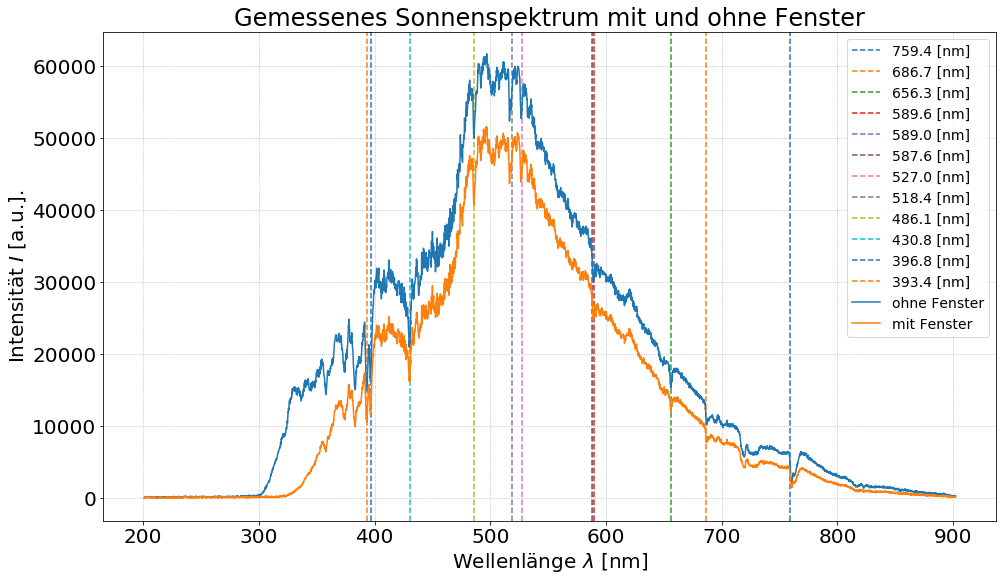

In [72]:
for x in range(0, lambda_FH.size):
    plt.axvline(x=lambda_FH[x],color='C'+str(x%10),linestyle='--', label=str(lambda_FH[x])+' [nm]')

plt.plot(x_s_og, i_s_og, label='ohne Fenster')    
plt.plot(x_s_mg, i_s_mg, label='mit Fenster')
plt.title('Gemessenes Sonnenspektrum mit und ohne Fenster')
plt.xlabel('Wellenlänge $\\lambda$ [nm]')
plt.ylabel('Intensität $I$ [a.u.].')
plt.legend(loc='best',fontsize=14)
plt.grid(ls=':')
plt.show()

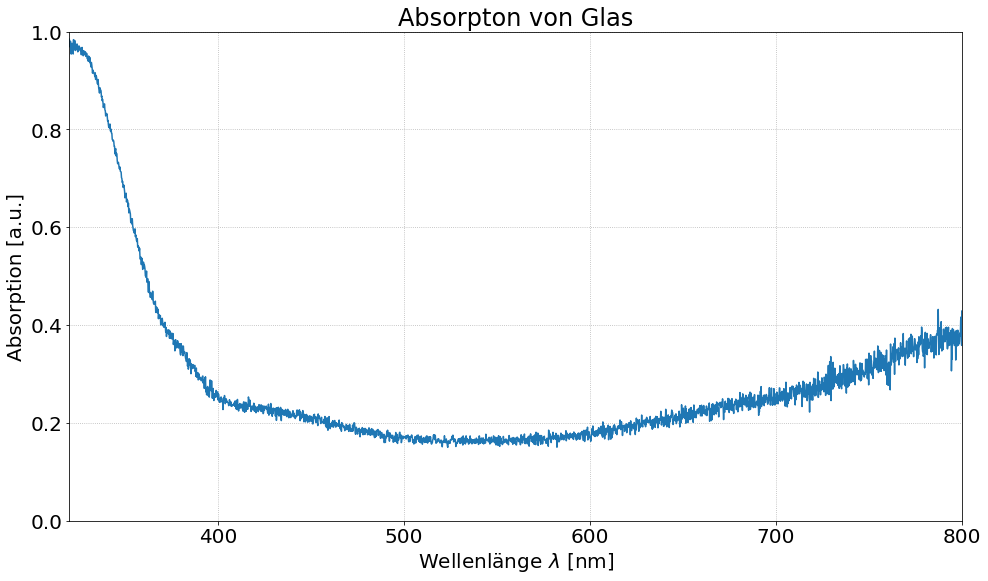

In [41]:
A=1-i_s_mg/i_s_og
plt.plot(x_s_mg, A)
plt.title('Absorpton von Glas')
plt.xlabel('Wellenlänge $\\lambda$ [nm]')
plt.ylabel('Absorption [a.u.]')
plt.grid(ls=':')
plt.ylim((0,1))
plt.xlim((320,800))
plt.show()

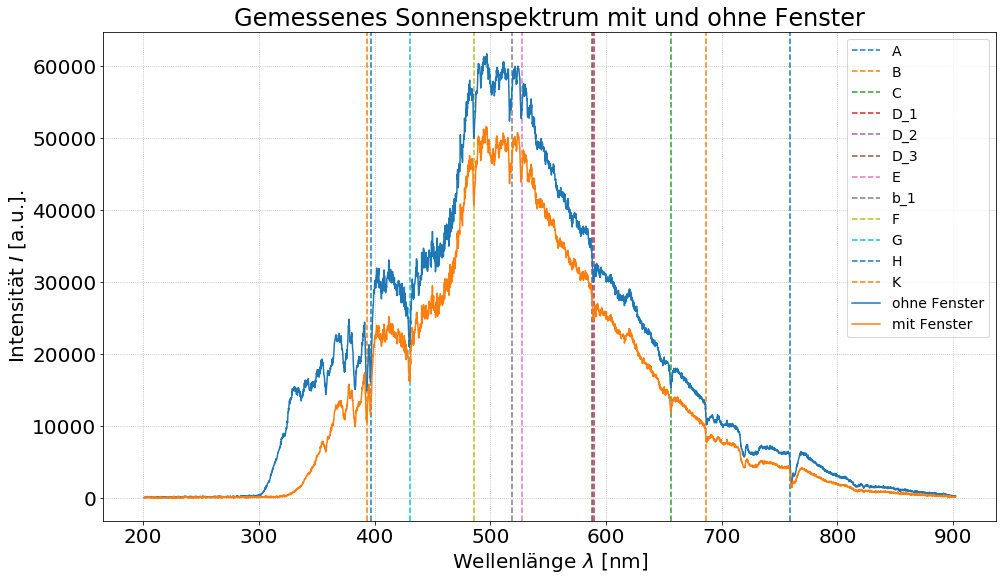

In [85]:
for x in range(0, lambda_FH.size):
    plt.axvline(x=lambda_FH[x],color='C'+str(x%10),linestyle='--', label=symbol_FH[x])

plt.plot(x_s_og, i_s_og, label='ohne Fenster')    
plt.plot(x_s_mg, i_s_mg, label='mit Fenster')
plt.title('Gemessenes Sonnenspektrum mit und ohne Fenster')
plt.xlabel('Wellenlänge $\\lambda$ [nm]')
plt.ylabel('Intensität $I$ [a.u.].')
plt.legend(loc='best',fontsize=14)
plt.grid(ls=':')
plt.show()

In [96]:
from scipy.signal import find_peaks
lamb_Na_1, inten_Na_1=np.loadtxt('data/Na niedrig.txt', skiprows=17, 
                                 converters= {0:comma_to_float, 1:comma_to_float},
                                 comments='>', unpack=True)
peaks1, _ = find_peaks(inten_Na_1, height=5e4,distance=100)

lamb_Na_2, inten_Na_2=np.loadtxt('data/Na mittel.txt', skiprows=17, 
                                 converters= {0:comma_to_float, 1:comma_to_float},
                                 comments='>', unpack=True)
peaks2, _ = find_peaks(inten_Na_2, height=1e4,distance=50)

lamb_Na_3, inten_Na_3=np.loadtxt('data/Na hoch.txt', skiprows=17, 
                                 converters= {0:comma_to_float, 1:comma_to_float},
                                 comments='>', unpack=True)
peaks3, _ = find_peaks(inten_Na_3, height=1e4,distance=100)

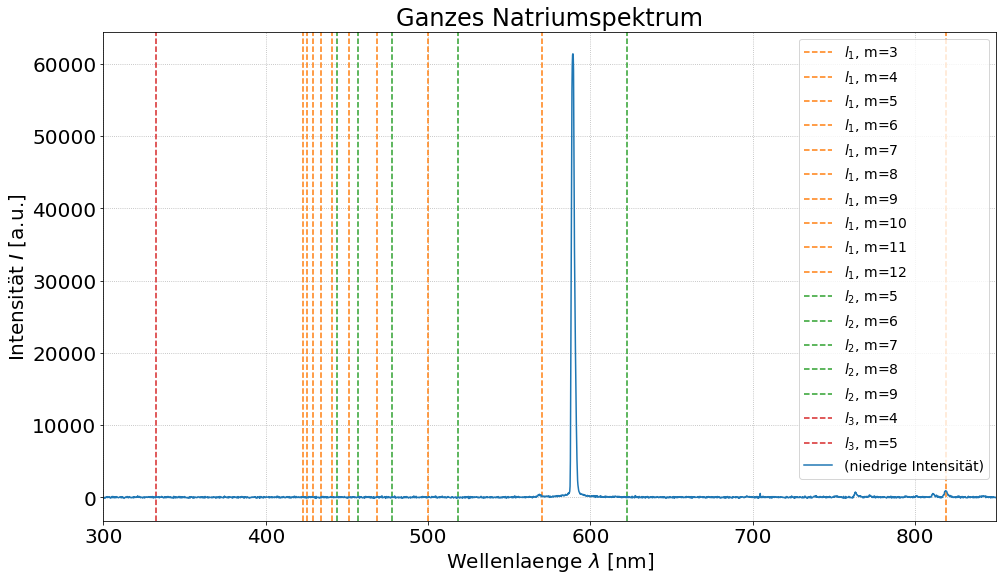

In [97]:
for x in range(3, 13):
    plt.axvline(x=l_1[x],color='C1',linestyle='--',label='$l_1$, m='+str(x))
for x in range(5, 10):
    plt.axvline(x=l_2[x],color='C2',linestyle='--',label='$l_2$, m='+str(x))
for x in range(4, 6):
    plt.axvline(x=l_3[x],color='C3',linestyle='--',label='$l_3$, m='+str(x))

plt.plot(lamb_Na_1, inten_Na_1, label='(niedrige Intensität)')
#plt.scatter(lamb_Na_1[peaks1], inten_Na_1[peaks1], label='Peaks')
plt.title('Ganzes Natriumspektrum')
plt.xlabel('Wellenlaenge $\\lambda$ [nm]')
plt.ylabel('Intensität $I$ [a.u.]')
plt.legend(loc='best',fontsize=14)
plt.grid(ls=':')
plt.xlim((300,850))
plt.show()

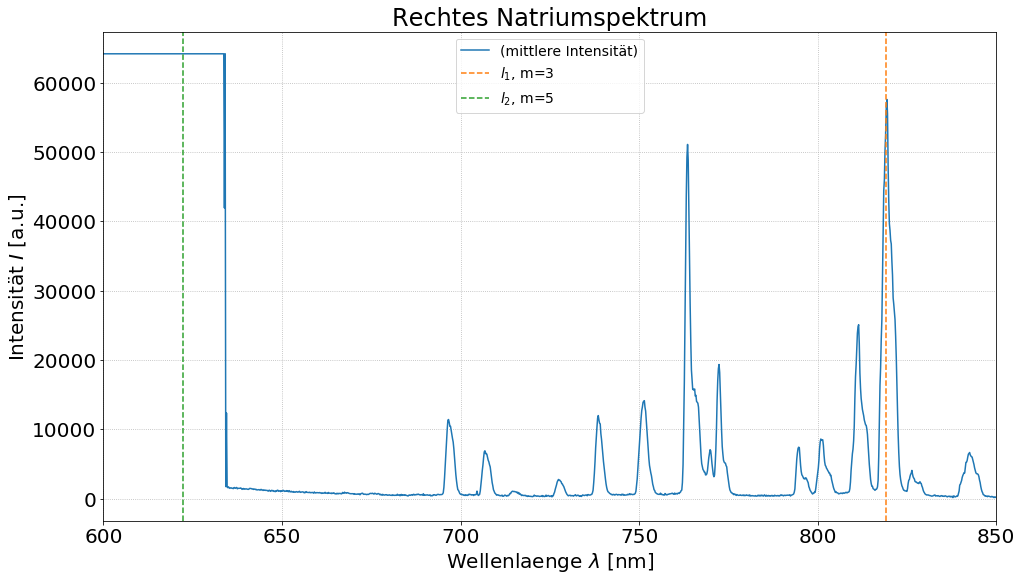

In [101]:
plt.plot(lamb_Na_2, inten_Na_2, label='(mittlere Intensität)')
for x in range(3, 4):
    plt.axvline(x=l_1[x],color='C1',linestyle='--',label='$l_1$, m='+str(x))
for x in range(5, 6):
    plt.axvline(x=l_2[x],color='C2',linestyle='--',label='$l_2$, m='+str(x))
plt.title('Rechtes Natriumspektrum')
plt.xlabel('Wellenlaenge $\\lambda$ [nm]')
plt.ylabel('Intensität $I$ [a.u.]')
plt.legend(loc='best',fontsize=14)
plt.grid(ls=':')
plt.xlim((600,850))
plt.show()

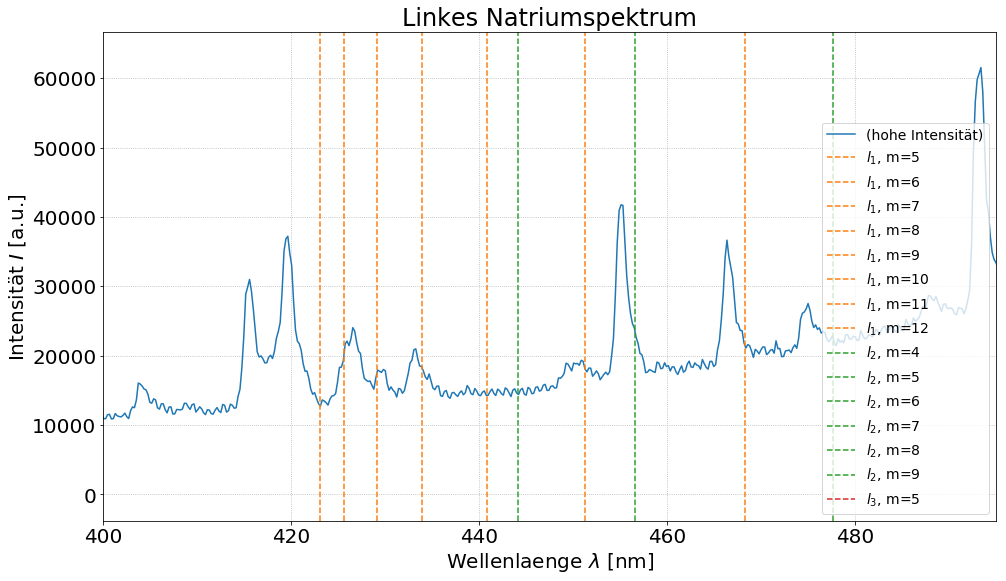

In [98]:
plt.plot(lamb_Na_3, inten_Na_3, label='(hohe Intensität)')
for x in range(3+2, 13):
    plt.axvline(x=l_1[x],color='C1',linestyle='--',label='$l_1$, m='+str(x))
for x in range(4, 10):
    plt.axvline(x=l_2[x],color='C2',linestyle='--',label='$l_2$, m='+str(x))
for x in range(5, 6):
    plt.axvline(x=l_3[x],color='C3',linestyle='--',label='$l_3$, m='+str(x))
plt.title('Linkes Natriumspektrum')
plt.xlabel('Wellenlaenge $\\lambda$ [nm]')
plt.ylabel('Intensität $I$ [a.u.]')
plt.legend(loc='best',fontsize=14)
plt.grid(ls=':')
plt.xlim((400,495))
plt.show()